In [1]:
import pickle
import numpy as np
import itertools
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

from contour_visualization import color_schemes, picture_cross, picture_contours, iso_lines, picture_plot
from contour_visualization.Gaussian import Gaussian

import scipy.stats as stats
import math

No module named 'mb_modelbase'


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
def get_gaussian(mu, variance, size=8000):
    sigma = math.sqrt(variance)
    a = mu + 4 * sigma
    b = mu - 4 * sigma
    x = np.linspace(a, b, size)
    return x, mu, sigma, a, b

In [4]:
colorsch = color_schemes.get_colorbrewer_schemes()

In [5]:
colors = color_schemes.get_representiv_colors(color_schemes.get_colorbrewer_schemes())

In [6]:
background_colorscheme = color_schemes.get_background_colorbrewer_scheme()
background_color = color_schemes.get_main_color(background_colorscheme)[-4]

In [7]:
colorsch

[{'colorscheme': <function contour_visualization.color_schemes.create_color_brewer_colorscheme(colorscheme_name, levels, lvl_white=1)>,
  'colorscheme_name': 'blue'},
 {'colorscheme': <function contour_visualization.color_schemes.create_color_brewer_colorscheme(colorscheme_name, levels, lvl_white=1)>,
  'colorscheme_name': 'orange'},
 {'colorscheme': <function contour_visualization.color_schemes.create_color_brewer_colorscheme(colorscheme_name, levels, lvl_white=1)>,
  'colorscheme_name': 'green'},
 {'colorscheme': <function contour_visualization.color_schemes.create_color_brewer_colorscheme(colorscheme_name, levels, lvl_white=1)>,
  'colorscheme_name': 'purple'},
 {'colorscheme': <function contour_visualization.color_schemes.create_color_brewer_colorscheme(colorscheme_name, levels, lvl_white=1)>,
  'colorscheme_name': 'red'}]

In [8]:
def get_polys(x, y, num_of_levels=6, colorscheme=colorsch[0], method="equal_density", min_value=0., max_value=1.):
    iso_level = iso_lines.get_iso_levels(y, method=method,
                                                  num_of_levels=num_of_levels)
    iso_lvl = iso_lines.get_iso_levels(y, method=method,
                                              num_of_levels=num_of_levels + 2)
    iso_lvl = picture_contours.get_color_middlepoint(iso_lvl, min_value, max_value)
    colors = picture_cross.get_color(iso_lvl, colorscheme)
    polys = []
    for i, keys in enumerate(zip([*iso_level, max(y)], colors)):
        lvl, color = keys
        if i == 0:
            filt = list(filter(lambda x: x[1] < lvl, zip(x , y)))
            verts = [(a, 0), *filt, (b, 0)]
        else:
            filt = list(filter(lambda x: biggest_points[0][1] <= x[1] < lvl, zip(x , y)))
            verts = [biggest_points[0], *filt, biggest_points[1]]
        filt.sort(key= lambda x: x[1])
        biggest_points = filt[-2:]
        polys.append([list(map(picture_cross.convert_to_int, verts)), color, 0.5])
    return polys

In [9]:
def split_list(line, avg_dist, scale=0.5):
    segments = []
    last = 0
    for i, seg in enumerate(zip(line[:-1], line[1:])):
        if abs(seg[1][0] - seg[0][0]) > avg_dist + (avg_dist * scale):
            if len(line[last:i]) != 0:
                segments.append(line[last:i])
                last = i
    if len(line[last:]) != 0:
        segments.append(line[last:])
    return segments

In [10]:
def get_polys_vert(x, y, num_of_levels=6, colorscheme=colorsch[0], method="equal_density", min_value=0., max_value=1.):
    iso_level = iso_lines.get_iso_levels(y, method=method,
                                                  num_of_levels=num_of_levels)
    iso_lvl = iso_lines.get_iso_levels(y, method=method,
                                              num_of_levels=num_of_levels + 2)
    iso_lvl = picture_contours.get_color_middlepoint(iso_lvl, min_value, max_value)
    colors = picture_cross.get_color(iso_lvl, colorscheme)
    polys = []
    for i, keys in enumerate(zip([*iso_level, max(y)], colors)):
        lvl, color = keys
        dist = sum(abs(y - x) for x,y in zip(x[:-1], x[1:]))/len(x)
        new_verts = []
        if i == 0:
            filt = list(filter(lambda x: x[1] < lvl, zip(x , y)))
            seg_filts = split_list(filt, dist)
            if len(seg_filts) > 1:
                new_verts.append([(a, 0), *seg_filts[0], (seg_filts[0][-1][0],0)])
                for seg in seg_filts[1:-1]:
                    new_verts.append([(seg[0][1],0), *seg[0], (seg[-1][1],0)])
                new_verts.append([(seg_filts[-1][0][0], 0), *seg_filts[-1], (b,0)])
            else:
                new_verts.append([(a, 0), *filt, (b, 0)])
        else:
            filt = list(filter(lambda x: biggest_points[0][1] <= x[1] < lvl, zip(x , y)))
            seg_filts = split_list(filt, dist)
            if len(seg_filts) > 1:
                for seg in seg_filts:
                    new_verts.append([(seg[0][0],0), *seg, (seg[-1][0],0)])
            else:
                new_verts.append([(a, 0), *filt, (b, 0)])
            verts = [biggest_points[0], *filt, biggest_points[1]]
        filt.sort(key= lambda x: x[1])
        biggest_points = filt[-2:]
        for verts in new_verts:
            polys.append([list(map(picture_cross.convert_to_int, verts)), color, 0.5])
    return polys

In [11]:
def fill_between_lines(axis, polys, color_space="lab"):
    for region in polys:
        idx, col = picture_cross.filter_order_color(region[1])
        z_weig = picture_cross.filter_order_list(region[2], idx)
        color = picture_cross.mix_colors(col, z_weig, color_space)
        axis.add_patch(Polygon(list(map(picture_cross.convert_to_float, region[0])), closed=True,
                               fill=True, edgecolor=color, facecolor=color, aa=True, linewidth=0.))

In [12]:
def plot_polys(axis, polys):
    for pol in polys:
        axis.add_patch(Polygon(list(map(picture_cross.convert_to_float, pol[0])), closed=True,
                       fill=True, edgecolor=pol[1], facecolor=pol[1], aa=True, linewidth=0.))

In [13]:
width = 12.5
height = 8.5
plt.rcParams['figure.figsize'] = [width, height]
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['legend.handlelength'] = 3
plt.rcParams['axes.labelsize'] = 25
plt.rcParams["legend.loc"] = "upper right"
plt.rcParams['axes.titlesize'] = 25

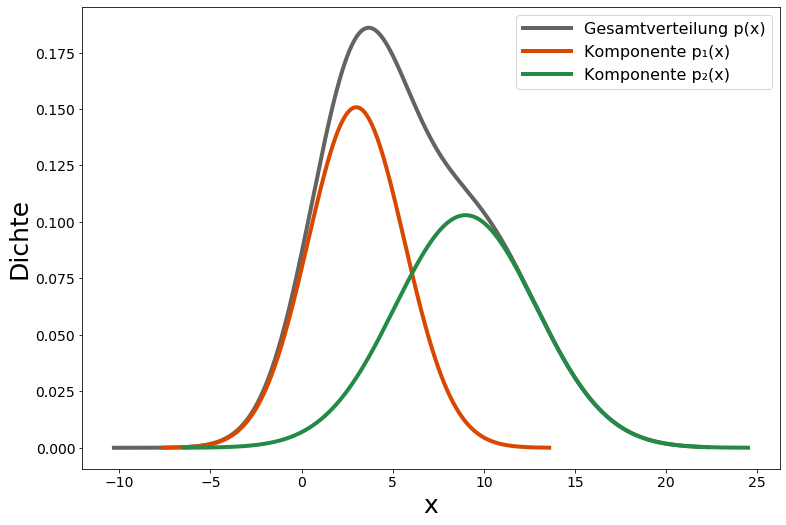

In [14]:

method="equal_density"
fig, ax = plt.subplots(1,1)

mu = -3
variance = 15
mu_1 = 3
variance_1 = 7
mu_2 = 9
variance_2 = 15

x_1, mu_1, sigma_1, a, b = get_gaussian(mu_1, variance_1)
y_1 = stats.norm.pdf(x_1, mu_1, sigma_1)
polys_1 = get_polys(x_1, y_1, 6, colorscheme=colorsch[1], method=method)


x_2, mu_2, sigma_2, a, b = get_gaussian(mu_2, variance_2)
y_2 = stats.norm.pdf(x_2, mu_2, sigma_2)
polys_2 = get_polys(x_2, y_2, 6, colorscheme=colorsch[2], method="equal_horizontal")





x_b = np.linspace(np.sum([mu_1, mu_2])/2 - 5 * np.sum([sigma_1, sigma_2])/2,
                np.sum([mu_1, mu_2])/2 + 5 * np.sum([sigma_1, sigma_2])/2, 4000)
y_b = stats.norm.pdf(x_b, *get_gaussian(mu_1, variance_1)[1:3]) + stats.norm.pdf(x_b, *get_gaussian(mu_2, variance_2)[1:3])


ax.plot(x_b, y_b, color=background_color, label="Gesamtverteilung p(x)", linewidth=4)
ax.plot(x_1, y_1, color=colors[1], label="Komponente p\u2081(x)", linewidth=4)
ax.plot(x_2, y_2, color=colors[2], label="Komponente p\u2082(x)", linewidth=4)
ax.set_xlabel("x")
ax.set_ylabel("Dichte")
ax.legend()
fig.savefig("first_example.png")

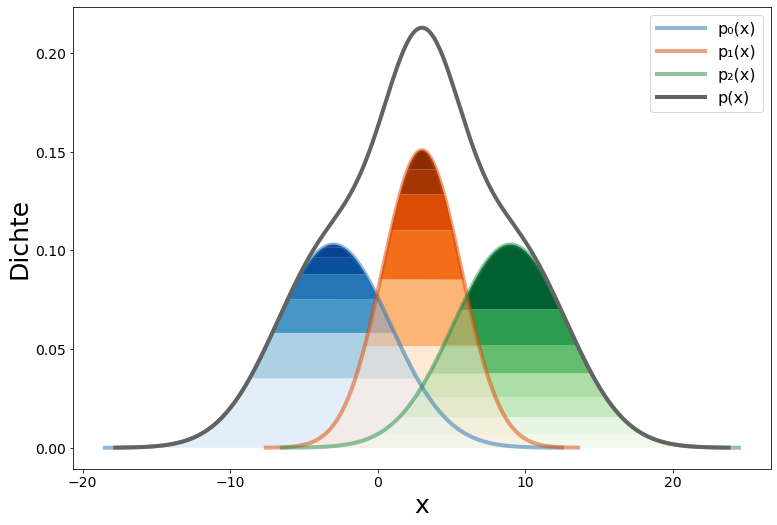

In [15]:

method="equal_density"
fig, ax = plt.subplots(1,1)

mu = -3
variance = 15
mu_1 = 3
variance_1 = 7
mu_2 = 9
variance_2 = 15

x, mu, sigma, a, b = get_gaussian(mu, variance)
y = stats.norm.pdf(x, mu, sigma)
polys = get_polys(x, y, 6, method=method)

x_1, mu_1, sigma_1, a, b = get_gaussian(mu_1, variance_1)
y_1 = stats.norm.pdf(x_1, mu_1, sigma_1)
polys_1 = get_polys(x_1, y_1, 6, colorscheme=colorsch[1], method=method)


x_2, mu_2, sigma_2, a, b = get_gaussian(mu_2, variance_2)
y_2 = stats.norm.pdf(x_2, mu_2, sigma_2)
polys_2 = get_polys(x_2, y_2, 6, colorscheme=colorsch[2], method="equal_horizontal")





x_b = np.linspace(np.sum([mu, mu_1, mu_2])/3 - 6 * np.sum([sigma, sigma_1, sigma_2])/3,
                np.sum([mu, mu_1, mu_2])/3 + 6 * np.sum([sigma, sigma_1, sigma_2])/3, 400)
y_b = stats.norm.pdf(x_b, *get_gaussian(mu, variance)[1:3]) + stats.norm.pdf(x_b, *get_gaussian(mu_1, variance_1)[1:3]) + stats.norm.pdf(x_b, *get_gaussian(mu_2, variance_2)[1:3])

plot_polys(ax, polys)
plot_polys(ax, polys_1)
plot_polys(ax, polys_2)

a = picture_cross.poly_union([polys, polys_1, polys_2])
a = picture_cross.multi_union(a, 3)
fill_between_lines(ax, a)

ax.plot(x, y, color=colors[0], label="p\u2080(x)", linewidth=4, alpha=0.5)
ax.plot(x_1, y_1, color=colors[1], label="p\u2081(x)", linewidth=4, alpha=0.5)
ax.plot(x_2, y_2, color=colors[2], label="p\u2082(x)", linewidth=4, alpha=0.5)
ax.plot(x_b, y_b, color=background_color, label="p(x)", linewidth=4)
ax.set_xlabel("x")
ax.set_ylabel("Dichte")
ax.legend()
fig.savefig("first_example.png")

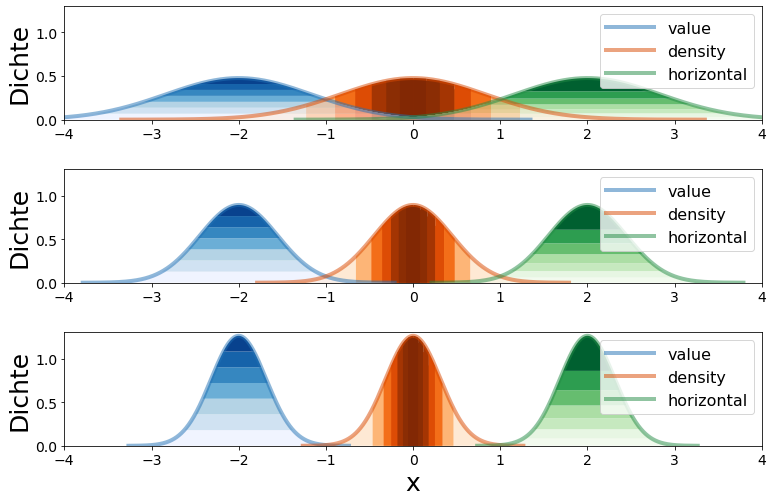

In [27]:
fig, (ax_0,ax_1, ax_2) = plt.subplots(3,1, sharex="row")

mu = -2
variance = 0.7
mu_1 = 0
variance_1 = 0.7
mu_2 = 2
variance_2 = .7

x, mu, sigma, a, b = get_gaussian(mu, variance)
y = stats.norm.pdf(x, mu, sigma)
polys = get_polys(x, y, 6, method="equal_value")

x_1, mu_1, sigma_1, a, b = get_gaussian(mu_1, variance_1)
y_1 = stats.norm.pdf(x_1, mu_1, sigma_1)
polys_1 = get_polys_vert(x_1, y_1, 6, colorscheme=colorsch[1], method="equal_density")


x_2, mu_2, sigma_2, a, b = get_gaussian(mu_2, variance_2)
y_2 = stats.norm.pdf(x_2, mu_2, sigma_2)
polys_2 = get_polys(x_2, y_2, 6, colorscheme=colorsch[2], method="equal_horizontal")





x_b = np.linspace(np.sum([mu, mu_1, mu_2])/3 - 12 * np.sum([sigma, sigma_1, sigma_2])/3,
                np.sum([mu, mu_1, mu_2])/3 + 12 * np.sum([sigma, sigma_1, sigma_2])/3, 400)
y_b = stats.norm.pdf(x_b, *get_gaussian(mu, variance)[1:3]) + stats.norm.pdf(x_b, *get_gaussian(mu_1, variance_1)[1:3]) + stats.norm.pdf(x_b, *get_gaussian(mu_2, variance_2)[1:3])

plot_polys(ax_0, polys)
plot_polys(ax_0, polys_1)
plot_polys(ax_0, polys_2)

a = picture_cross.poly_union([polys, polys_1, polys_2])
fill_between_lines(ax_0, a)
a = picture_cross.multi_union(a, 3)

ax_0.plot(x, y, color=colors[0], label="value", linewidth=4, alpha=0.5)
ax_0.plot(x_1, y_1, color=colors[1], label="density", linewidth=4, alpha=0.5)
ax_0.plot(x_2, y_2, color=colors[2], label="horizontal", linewidth=4, alpha=0.5)
# ax.plot(x_b, y_b, color=background_color, label="p(x)", linewidth=4)
ax_0.set_ylabel("Dichte")
ax_0.legend()

mu = -2
variance = 0.2
mu_1 = 0
variance_1 = 0.2
mu_2 = 2
variance_2 = 0.2

x, mu, sigma, a, b = get_gaussian(mu, variance)
y = stats.norm.pdf(x, mu, sigma)
polys = get_polys(x, y, 6, method="equal_value")

x_1, mu_1, sigma_1, a, b = get_gaussian(mu_1, variance_1)
y_1 = stats.norm.pdf(x_1, mu_1, sigma_1)
polys_1 = get_polys_vert(x_1, y_1, 6, colorscheme=colorsch[1], method="equal_density")


x_2, mu_2, sigma_2, a, b = get_gaussian(mu_2, variance_2)
y_2 = stats.norm.pdf(x_2, mu_2, sigma_2)
polys_2 = get_polys(x_2, y_2, 6, colorscheme=colorsch[2], method="equal_horizontal")





x_b = np.linspace(np.sum([mu, mu_1, mu_2])/3 - 12 * np.sum([sigma, sigma_1, sigma_2])/3,
                np.sum([mu, mu_1, mu_2])/3 + 12 * np.sum([sigma, sigma_1, sigma_2])/3, 400)
y_b = stats.norm.pdf(x_b, *get_gaussian(mu, variance)[1:3]) + stats.norm.pdf(x_b, *get_gaussian(mu_1, variance_1)[1:3]) + stats.norm.pdf(x_b, *get_gaussian(mu_2, variance_2)[1:3])

plot_polys(ax_1, polys)
plot_polys(ax_1, polys_1)
plot_polys(ax_1, polys_2)

a = picture_cross.poly_union([polys, polys_1, polys_2])
a = picture_cross.multi_union(a, 3)
fill_between_lines(ax_1, a)

ax_1.plot(x, y, color=colors[0], label="value", linewidth=4, alpha=0.5)
ax_1.plot(x_1, y_1, color=colors[1], label="density", linewidth=4, alpha=0.5)
ax_1.plot(x_2, y_2, color=colors[2], label="horizontal", linewidth=4, alpha=0.5)
# ax.plot(x_b, y_b, color=background_color, label="p(x)", linewidth=4)
ax_1.set_ylabel("Dichte")
ax_1.legend()



mu = -2
variance = 0.1
mu_1 = 0
variance_1 = 0.1
mu_2 = 2
variance_2 = 0.1

x, mu, sigma, a, b = get_gaussian(mu, variance)
y = stats.norm.pdf(x, mu, sigma)
polys = get_polys(x, y, 6, method="equal_value")

x_1, mu_1, sigma_1, a, b = get_gaussian(mu_1, variance_1)
y_1 = stats.norm.pdf(x_1, mu_1, sigma_1)
polys_1 = get_polys_vert(x_1, y_1, 6, colorscheme=colorsch[1], method="equal_density")


x_2, mu_2, sigma_2, a, b = get_gaussian(mu_2, variance_2)
y_2 = stats.norm.pdf(x_2, mu_2, sigma_2)
polys_2 = get_polys(x_2, y_2, 6, colorscheme=colorsch[2], method="equal_horizontal")





x_b = np.linspace(np.sum([mu, mu_1, mu_2])/3 - 12 * np.sum([sigma, sigma_1, sigma_2])/3,
                np.sum([mu, mu_1, mu_2])/3 + 12 * np.sum([sigma, sigma_1, sigma_2])/3, 400)
y_b = stats.norm.pdf(x_b, *get_gaussian(mu, variance)[1:3]) + stats.norm.pdf(x_b, *get_gaussian(mu_1, variance_1)[1:3]) + stats.norm.pdf(x_b, *get_gaussian(mu_2, variance_2)[1:3])

plot_polys(ax_2, polys)
plot_polys(ax_2, polys_1)
plot_polys(ax_2, polys_2)

a = picture_cross.poly_union([polys, polys_1, polys_2])
a = picture_cross.multi_union(a, 3)
fill_between_lines(ax_2, a)

ax_2.plot(x, y, color=colors[0], label="value", linewidth=4, alpha=0.5)
ax_2.plot(x_1, y_1, color=colors[1], label="density", linewidth=4, alpha=0.5)
ax_2.plot(x_2, y_2, color=colors[2], label="horizontal", linewidth=4, alpha=0.5)
# ax.plot(x_b, y_b, color=background_color, label="p(x)", linewidth=4)
ax_2.set_xlabel("x")
ax_2.set_ylabel("Dichte")
ax_2.legend()


ax_0.set_xlim(-4, 4)
ax_0.set_ylim(0, 1.3)
ax_1.set_xlim(-4, 4)
ax_1.set_ylim(0, 1.3)
ax_2.set_xlim(-4, 4)
ax_2.set_ylim(0, 1.3)

ax_0.set_aspect('equal')
ax_1.set_aspect('equal')
ax_2.set_aspect('equal')

pos = ax_0.get_position()
pos2 = ax_1.get_position()
ax_1.set_position([pos.x0, pos2.y0, pos.width, pos2.height])

fig.savefig("iso_line_types.png")

NameError: name 'picture' is not defined

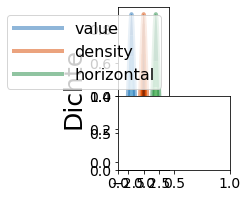

In [18]:
fig = plt.figure(figsize=(2,3)) #, sharex="row"

mu = -2
variance = 0.7
mu_1 = 0
variance_1 = 0.7
mu_2 = 2
variance_2 = .7

x, mu, sigma, a, b = get_gaussian(mu, variance)
y = stats.norm.pdf(x, mu, sigma)
polys = get_polys(x, y, 6, method="equal_value")

x_1, mu_1, sigma_1, a, b = get_gaussian(mu_1, variance_1)
y_1 = stats.norm.pdf(x_1, mu_1, sigma_1)
polys_1 = get_polys_vert(x_1, y_1, 6, colorscheme=colorsch[1], method="equal_density")


x_2, mu_2, sigma_2, a, b = get_gaussian(mu_2, variance_2)
y_2 = stats.norm.pdf(x_2, mu_2, sigma_2)
polys_2 = get_polys(x_2, y_2, 6, colorscheme=colorsch[2], method="equal_horizontal")





x_b = np.linspace(np.sum([mu, mu_1, mu_2])/3 - 12 * np.sum([sigma, sigma_1, sigma_2])/3,
                np.sum([mu, mu_1, mu_2])/3 + 12 * np.sum([sigma, sigma_1, sigma_2])/3, 400)
y_b = stats.norm.pdf(x_b, *get_gaussian(mu, variance)[1:3]) + stats.norm.pdf(x_b, *get_gaussian(mu_1, variance_1)[1:3]) + stats.norm.pdf(x_b, *get_gaussian(mu_2, variance_2)[1:3])

plot_polys(ax_0, polys)
plot_polys(ax_0, polys_1)
plot_polys(ax_0, polys_2)

a = picture_cross.poly_union([polys, polys_1, polys_2])
fill_between_lines(ax_0, a)
a = picture_cross.multi_union(a, 3)

ax_0.plot(x, y, color=colors[0], label="value", linewidth=4, alpha=0.5)
ax_0.plot(x_1, y_1, color=colors[1], label="density", linewidth=4, alpha=0.5)
ax_0.plot(x_2, y_2, color=colors[2], label="horizontal", linewidth=4, alpha=0.5)
# ax.plot(x_b, y_b, color=background_color, label="p(x)", linewidth=4)
ax_0.set_ylabel("Dichte")
ax_0.legend()

mu = -2
variance = 0.2
mu_1 = 0
variance_1 = 0.2
mu_2 = 2
variance_2 = 0.2

x, mu, sigma, a, b = get_gaussian(mu, variance)
y = stats.norm.pdf(x, mu, sigma)
polys = get_polys(x, y, 6, method="equal_value")

x_1, mu_1, sigma_1, a, b = get_gaussian(mu_1, variance_1)
y_1 = stats.norm.pdf(x_1, mu_1, sigma_1)
polys_1 = get_polys_vert(x_1, y_1, 6, colorscheme=colorsch[1], method="equal_density")


x_2, mu_2, sigma_2, a, b = get_gaussian(mu_2, variance_2)
y_2 = stats.norm.pdf(x_2, mu_2, sigma_2)
polys_2 = get_polys(x_2, y_2, 6, colorscheme=colorsch[2], method="equal_horizontal")





x_b = np.linspace(np.sum([mu, mu_1, mu_2])/3 - 12 * np.sum([sigma, sigma_1, sigma_2])/3,
                np.sum([mu, mu_1, mu_2])/3 + 12 * np.sum([sigma, sigma_1, sigma_2])/3, 400)
y_b = stats.norm.pdf(x_b, *get_gaussian(mu, variance)[1:3]) + stats.norm.pdf(x_b, *get_gaussian(mu_1, variance_1)[1:3]) + stats.norm.pdf(x_b, *get_gaussian(mu_2, variance_2)[1:3])


ax_1 = fig.add_subplot(1, 2, 1)
plot_polys(ax_1, polys)
plot_polys(ax_1, polys_1)
plot_polys(ax_1, polys_2)

a = picture_cross.poly_union([polys, polys_1, polys_2])
a = picture_cross.multi_union(a, 3)
fill_between_lines(ax_1, a)

ax_1.plot(x, y, color=colors[0], label="value", linewidth=4, alpha=0.5)
ax_1.plot(x_1, y_1, color=colors[1], label="density", linewidth=4, alpha=0.5)
ax_1.plot(x_2, y_2, color=colors[2], label="horizontal", linewidth=4, alpha=0.5)
# ax.plot(x_b, y_b, color=background_color, label="p(x)", linewidth=4)
ax_1.set_ylabel("Dichte")
ax_1.legend()

ax_2 = fig.add_subplot(2, 1, 2)

gau_1 = Gaussian(means=[mu_1, mu_1], cov_matrix=[[variance_1,0],[0,variance_1]])

picture

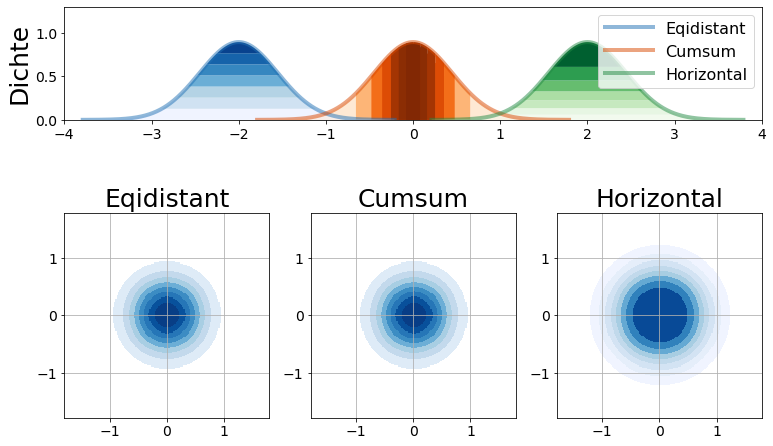

In [21]:
ax_1 = plt.subplot(211)
ax_2 = plt.subplot(234)
ax_3 = plt.subplot(235, sharey=ax_2)
ax_4 = plt.subplot(236, sharey=ax_2)
# ax_1.grid(True)
ax_2.grid(True)
ax_3.grid(True)
ax_4.grid(True)

mu = -2
variance = 0.2
mu_1 = 0
variance_1 = 0.2
mu_2 = 2
variance_2 = 0.2

x, mu, sigma, a, b = get_gaussian(mu, variance)
y = stats.norm.pdf(x, mu, sigma)
polys = get_polys(x, y, 6, method="equal_value")

x_1, mu_1, sigma_1, a, b = get_gaussian(mu_1, variance_1)
y_1 = stats.norm.pdf(x_1, mu_1, sigma_1)
polys_1 = get_polys_vert(x_1, y_1, 6, colorscheme=colorsch[1], method="equal_density")


x_2, mu_2, sigma_2, a, b = get_gaussian(mu_2, variance_2)
y_2 = stats.norm.pdf(x_2, mu_2, sigma_2)
polys_2 = get_polys(x_2, y_2, 6, colorscheme=colorsch[2], method="equal_horizontal")

x_b = np.linspace(np.sum([mu, mu_1, mu_2])/3 - 12 * np.sum([sigma, sigma_1, sigma_2])/3,
                np.sum([mu, mu_1, mu_2])/3 + 12 * np.sum([sigma, sigma_1, sigma_2])/3, 400)
y_b = stats.norm.pdf(x_b, *get_gaussian(mu, variance)[1:3]) + stats.norm.pdf(x_b, *get_gaussian(mu_1, variance_1)[1:3]) + stats.norm.pdf(x_b, *get_gaussian(mu_2, variance_2)[1:3])



plot_polys(ax_1, polys)
plot_polys(ax_1, polys_1)
plot_polys(ax_1, polys_2)

a = picture_cross.poly_union([polys, polys_1, polys_2])
a = picture_cross.multi_union(a, 3)
fill_between_lines(ax_1, a)

names = ["Eqidistant", "Cumsum", "Horizontal"]
ax_1.plot(x, y, color=colors[0], label=names[0], linewidth=4, alpha=0.5)
ax_1.plot(x_1, y_1, color=colors[1], label=names[1], linewidth=4, alpha=0.5)
ax_1.plot(x_2, y_2, color=colors[2], label=names[2], linewidth=4, alpha=0.5)
ax_1.set_ylabel("Dichte")
ax_1.legend()

cov_matrix = [[0.2,0],[0,0.2]]
gau = Gaussian(means=[mu_1, mu_1], cov_matrix=cov_matrix)

ax_2.set_title(names[0])
ax_3.set_title(names[1])
ax_4.set_title(names[2])
picture_plot.plot_image(ax_2, [gau], contours=True, contour_method="equal_value")
picture_plot.plot_image(ax_3, [gau], contours=True, contour_method="equal_density")
picture_plot.plot_image(ax_4, [gau], contours=True, contour_method="equal_horizontal")

ax_1.set_xlim(-4, 4)
ax_1.set_ylim(0, 1.3)
ax_1.set_aspect('equal')
plt.savefig("iso_line_types.png")

horizontal density --> nur limitierte anzahl an kanten --> alle im peak, der rest ist nicht dargestellt --> informationsverlust